# Added Option 3 - View Analytics

Following Operations are available:
1: Room Price Computation(New Bookings)
2: Booking Receipt Generation(On Completion)
3. View SmartStay Analytics.


Enter your choice(1/2/3):  3


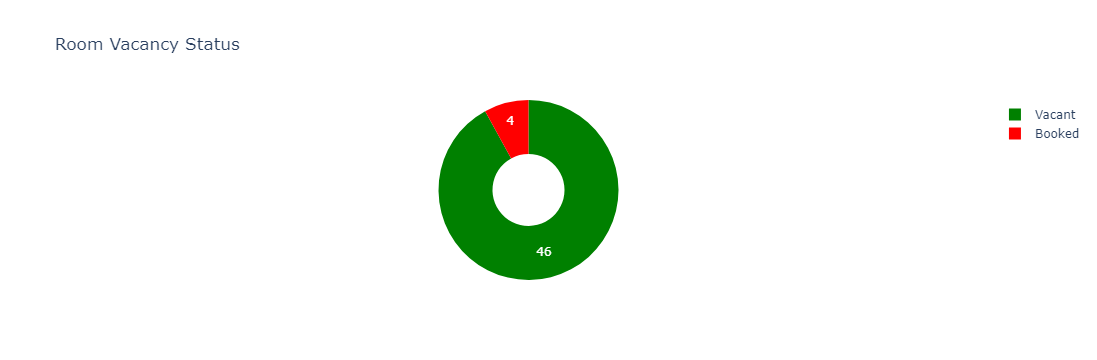

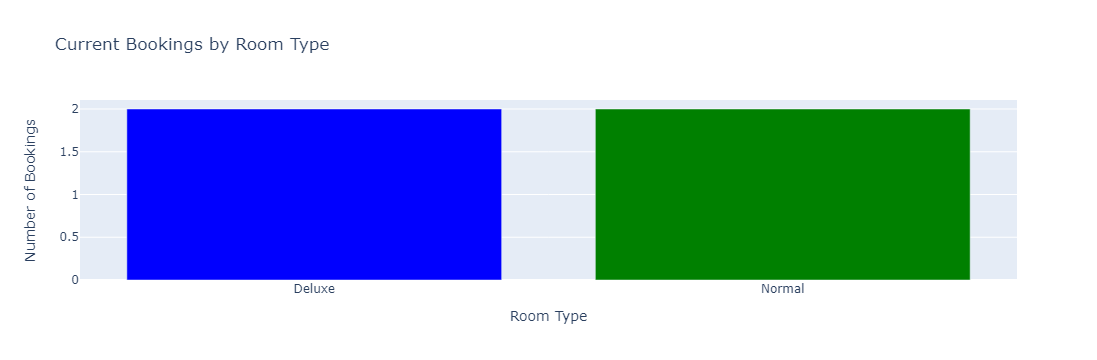

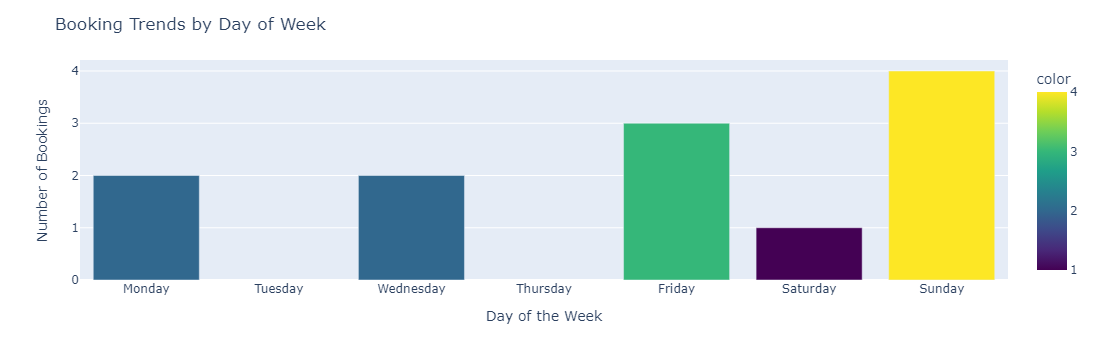

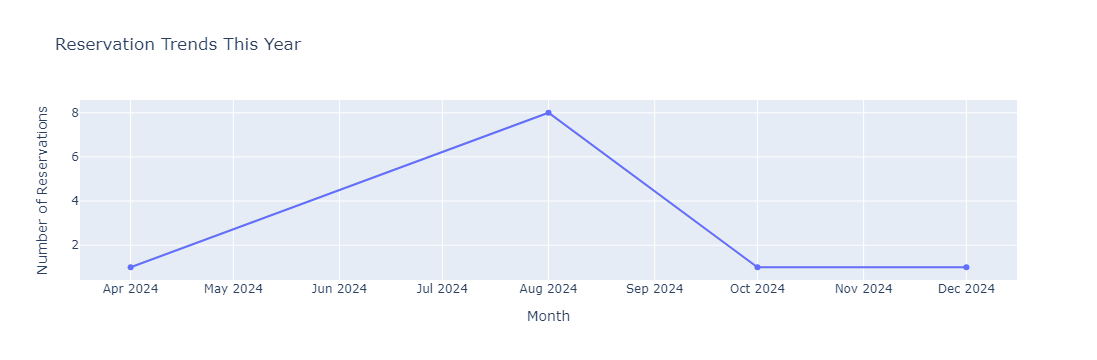

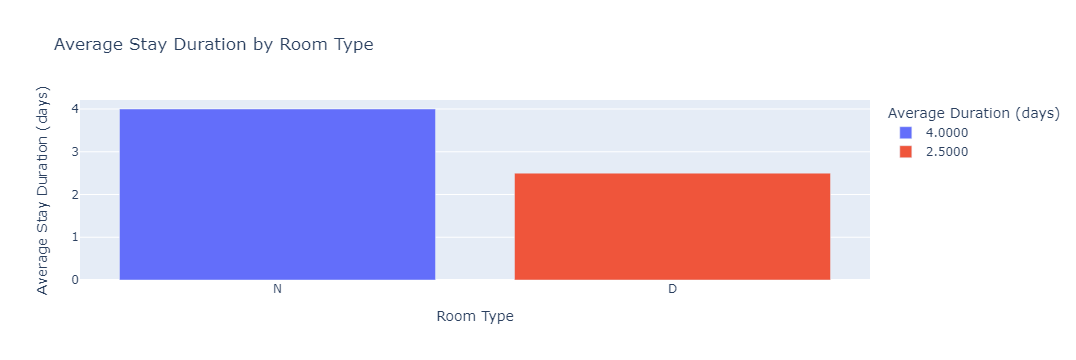

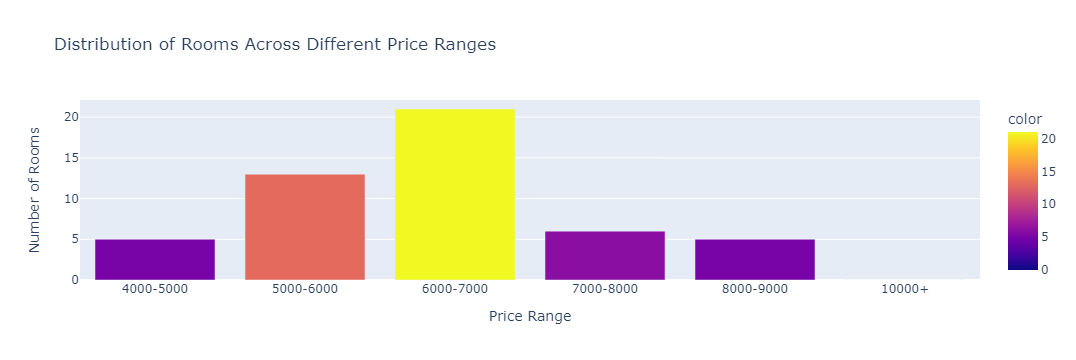

In [7]:
def main():
    print("Following Operations are available:")
    print("1: Room Price Computation(New Bookings)")
    print("2: Booking Receipt Generation(On Completion)")
    print("3. View SmartStay Analytics.")
    choice = input("Enter your choice(1/2/3): ")

    if choice == '1':
        room_price_computation()  # Function for Room price computation 
    elif choice == '2':
        room_no_input = input("Enter the room number: ")
        session = Session()
        fetch_reservation_and_calculate(int(room_no_input), session)  # Function from receipt generation
    elif choice == '3':
        view_Analytics()
    else:
        print("Invalid choice. Please enter 1/2/3")

# function for room price computation (Option 1)
def room_price_computation():
    from sqlalchemy import create_engine, Column, Integer, String, Boolean, DateTime, ForeignKey, text
    from sqlalchemy.orm import declarative_base, sessionmaker, relationship
    import datetime
    from prettytable import PrettyTable
    import matplotlib.pyplot as plt
    import time
    from IPython.display import display, clear_output
    from fpdf import FPDF
    import pandas as pd
    import smtplib
    from email.mime.multipart import MIMEMultipart
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    import yagmail 
    
    # Database connection parameters
    username = 'root'
    password = 'iamukr77'
    host = 'localhost'
    port = '3306'  # Default MySQL port
    database = 'smartstay'  # Your schema name

    # Create an engine instance with provided credentials
    engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

    # Define the ORM base class
    Base = declarative_base()
    
    # Define the ORM mapping for the rooms table
    class Room(Base):
        __tablename__ = 'rooms'
        id = Column(Integer, primary_key=True, autoincrement=True)
        room_no = Column(Integer, unique=True)
        price = Column(Integer)
        room_type = Column(String(2))
        currently_booked = Column(Boolean, default=False)
        created_at = Column(DateTime, default=datetime.datetime.utcnow)

        reservations = relationship("Reservation", back_populates="room")
        
    class Reservation(Base):
        __tablename__ = 'reservations'
        id = Column(Integer, primary_key=True, autoincrement=True)
        g_id = Column(Integer, ForeignKey('guests.id'))
        r_date = Column(DateTime)
        check_in = Column(DateTime)
        check_out = Column(DateTime)
        meal = Column(Boolean)
        r_id = Column(Integer, ForeignKey('rooms.id'))
        r_type = Column(String(2))
        created_at = Column(DateTime, default=datetime.datetime.utcnow)

        guest = relationship("Guest", back_populates="reservations")
        room = relationship("Room", back_populates="reservations")

     # Define the ORM mapping for the guests table
    class Guest(Base):
        __tablename__ = 'guests'
        id = Column(Integer, primary_key=True, autoincrement=True)
        name = Column(String(30))
        address = Column(String(50))
        email_id = Column(String(50))
        phone = Column(Integer)
        city = Column(String(20))
        created_at = Column(DateTime, default=datetime.datetime.utcnow)

        reservations = relationship("Reservation", back_populates="guest")

    # Define the ORM mapping for the loyalty table
    class Loyalty(Base):
        __tablename__ = 'loyalty'
        id = Column(Integer, primary_key=True, autoincrement=True)
        guest_id = Column(Integer, ForeignKey('guests.id'))
        email_id = Column(String(50), default=None)
        created_at = Column(DateTime, default=datetime.datetime.utcnow)


    # Create a sessionmaker
    Session = sessionmaker(bind=engine)

    # Function to apply Early Bird Discount and Late Minute Price Surge
    def early_and_late(current_price, reservation):
        previous_price = current_price
    
        # Calculate days between reservation creation and check-in date
        days_in_advance = (reservation.check_in - reservation.created_at).days
    
        # Apply Early Bird Discount
        if days_in_advance >= 90:
            discount = 0.10 + (days_in_advance - 90) / 10 * 0.05  # 10% - 15% discount
            current_price = int(current_price * (1 - min(discount, 0.15)))
    
        # Apply Late Minute Price Surge
        if days_in_advance < 3:
            surge = 0.10 + (3 - days_in_advance) / 3 * 0.10  # 10% - 20% increase
            current_price = int(current_price * (1 + min(surge, 0.20)))
    
        percentage_change = ((current_price - previous_price) / previous_price) * 100
        sign = "+" if percentage_change > 0 else ""
        print(f"Price after Smart Booking Optimization => {current_price} ({sign}{percentage_change:.2f}%)")
        return current_price, f"{sign}{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

    # Function to calculate dynamic price based on room type, weekends, and summer season
    def calculate_dynamic_price(room, reservation):
        prices = []
        labels = []
        changes = []
    
        base_price = 5000  # Example base price
        prices.append(base_price)
        labels.append('Initial Price')
        changes.append('')
        print(f"Initial Price => {base_price}")

        # Adjust price based on room type
        previous_price = base_price
        if room.room_type == 'D':  # Deluxe room
            base_price += 1000
        elif room.room_type == 'N':  # Normal room
            base_price += 500
    
        percentage_change = ((base_price - previous_price) / previous_price) * 100
        prices.append(base_price)
        labels.append('Room Type Adjustment')
        changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
        print(f"Price After Room Type Adjustment => {base_price} ({changes[-1]})")
    
        # Check if the check_in date was a weekend
        previous_price = base_price
        created_at_date = reservation.check_in
        is_weekend_flag = created_at_date.weekday() >= 5  # 5 represents Saturday, 6 represents Sunday

        if is_weekend_flag:
            base_price *= 1.05  # Increase price by 5% for rooms created on weekends

        percentage_change = ((base_price - previous_price) / previous_price) * 100
        prices.append(int(base_price))
        labels.append('Weekend Surge Charge')
        changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
        print(f"Price After Weekend Surge Charge => {int(base_price)} ({changes[-1]})")
    
        # Check if the created_at date falls within the summer season (March and April)
        previous_price = base_price
        if created_at_date.month in [3, 4]:
            base_price *= 1.15  # Increase price by 15% for rooms booked during the summer season
    
        percentage_change = ((base_price - previous_price) / previous_price) * 100
        prices.append(int(base_price))
        labels.append('Summer Season Adjustment')
        changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
        print(f"Price After Summer Season Adjustment => {int(base_price)} ({changes[-1]})")

        # Special high price periods with linear interpolation
        high_price_periods = [
        (datetime.datetime(2024, 1, 13), datetime.datetime(2024, 1, 15), 1.20, 1.30),  # Makar Sankranti (Long weekend)
        (datetime.datetime(2024, 3, 8), datetime.datetime(2024, 3, 8), 1.20, 1.30),  # Holi
        (datetime.datetime(2024, 4, 7), datetime.datetime(2024, 4, 10), 1.20, 1.30),  # Good Friday & Easter Weekend
        (datetime.datetime(2024, 10, 11), datetime.datetime(2024, 10, 15), 1.20, 1.30),  # Navratri and Dussehra
        (datetime.datetime(2024, 12, 23), datetime.datetime(2024, 12, 31), 1.20, 1.30),   # Christmas to New Year’s Eve
        ]

        # Apply high price adjustments based on special periods
        for start_date, end_date, min_multiplier, max_multiplier in high_price_periods:
            if start_date <= created_at_date <= end_date:
                # Calculate the fraction of the period that has passed
                total_period = (end_date - start_date).days
                days_passed = (created_at_date - start_date).days
                fraction_passed = days_passed / total_period
            
                # Linearly interpolate price based on the fraction of the period passed
                current_multiplier = min_multiplier + (max_multiplier - min_multiplier) * fraction_passed
                previous_price = base_price
                base_price *= current_multiplier
                percentage_change = ((base_price - previous_price) / previous_price) * 100
                prices.append(int(base_price))
                labels.append('Festive Period Amendments')
                changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
                print(f"Price After Festive Period Amendments => {int(base_price)} ({changes[-1]})")
                break  # Exit loop after Festive Periiod adjustment
    
        return int(base_price), prices, labels, changes

    # Function to check if the room is booked
    def is_room_booked(room_no, session):
        reservation = session.query(Reservation).join(Room).filter(Room.room_no == room_no, Reservation.check_out == None).first()
        return reservation is not None

    # Function to apply dynamic price based on room availability
    def update_room_price(room_no, session, current_price):
        previous_price = current_price
        if is_room_booked(room_no, session):
            current_price *= 1.18  # Increase price by 18%
    
        percentage_change = ((current_price - previous_price) / previous_price) * 100
        print(f"Price After Room Availability Charge => {int(current_price)} ({f'+{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
        return int(current_price), f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

    # Function to apply loyalty discount
    def apply_loyalty_discount(current_price, guest, session):
        previous_price = current_price

        # Check if the guest's email_id is in the loyalty table
        loyalty_member = session.query(Loyalty).filter_by(email_id=guest.email_id).first()

        if loyalty_member:
            current_price = int(current_price * 0.8)  # Apply 20% discount

        percentage_change = ((current_price - previous_price) / previous_price) * 100
        print(f"Price After Loyalty Discount => {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
        return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"
 

    # Function to apply special offer period specific date
    def apply_special_offer(current_price, reservation):
        previous_price = current_price
        offer_start_date = datetime.datetime(2024, 4, 20)
        offer_end_date = datetime.datetime(2024, 4, 30)
    
        if offer_start_date <= reservation.check_in <= offer_end_date:
            current_price = int(current_price * 0.93)  # Apply 7% discount

    # Function to apply special offer period specific date
    def apply_special_offer(current_price, reservation):
        previous_price = current_price
        offer_start_date = datetime.datetime(2024, 4, 20)
        offer_end_date = datetime.datetime(2024, 4, 30)
        if offer_start_date <= reservation.check_in <= offer_end_date:
            current_price = int(current_price * 0.93)  # Apply 7% discount

        # Discount periods for holidays
        holiday_discounts = [
        (datetime.datetime(2024, 2, 1), datetime.datetime(2024, 2, 28), 0.85, 0.75),  # February discount range
        (datetime.datetime(2024, 7, 15), datetime.datetime(2024, 9, 7), 0.85, 0.75),  # Mid-July to Early September discount range
        (datetime.datetime(2024, 11, 1), datetime.datetime(2024, 11, 30), 0.85, 0.75),  # After Diwali discount range

        ]

        # Apply discounts based on holiday periods
        for start_date, end_date, min_discount, max_discount in holiday_discounts:
            if start_date <= reservation.check_in <= end_date:
                # Calculate the fraction of the period that has passed
                total_period = (end_date - start_date).days
                days_passed = (reservation.check_in - start_date).days
                fraction_passed = days_passed / total_period
            
                # Linearly interpolate discount based on the fraction of the period passed
                current_discount = min_discount + (max_discount - min_discount) * fraction_passed
                current_price = int(current_price * current_discount)
                break  # Exit loop after applying discount
    
        percentage_change = ((current_price - previous_price) / previous_price) * 100
        print(f"Price After Special Offer Period => {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
        return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

    def apply_peak_load_pricing(current_price, total_rooms, vacant_rooms):
        previous_price = current_price

        # Calculate occupancy rate
        occupancy_rate = ((total_rooms - vacant_rooms) / total_rooms) * 100

        # Set thresholds and percentage adjustments
        low_occupancy_threshold = 25
        high_occupancy_threshold = 85  # or 90.0 based on your preference
        low_occupancy_decrease = 0.90    # Decrease by 10% if occupancy is below the low threshold
        high_occupancy_increase = 1.15   # Increase by 15% if occupancy is above the high threshold

        # Adjust prices based on occupancy rate
        if occupancy_rate <= low_occupancy_threshold:
            current_price = int(current_price * low_occupancy_decrease)
        elif occupancy_rate >= high_occupancy_threshold:
            current_price = int(current_price * high_occupancy_increase)

        percentage_change = ((current_price - previous_price) / previous_price) * 100
        sign = "+" if percentage_change > 0 else ""
        print(f"Price After Peak-Load Pricing => {current_price} ({f'{sign}{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
        return current_price, f"{sign}{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

    # Function to fetch and display guest information along with reservation and room details
    def get_guest_info(guest_id, session, final_price, prices, labels, changes):
        guest = session.query(Guest).filter_by(id=guest_id).first()
        reservation = session.query(Reservation).filter_by(g_id=guest_id, check_out=None).first()
        room = session.query(Room).filter_by(id=reservation.r_id).first() if reservation else None
    
        current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
        if guest and reservation and room:
            # Create a PrettyTable instance
            table = PrettyTable()
            table.field_names = ["Field", "Data"]
            table.max_width["Field"] = 20
            table.max_width["Data"] = 50
            table.add_row(["Name", guest.name])
            table.add_row(["Address", guest.address])
            table.add_row(["Email", guest.email_id])
            table.add_row(["Phone", guest.phone])
            table.add_row(["Check-in Date", reservation.check_in.strftime('%Y-%m-%d %H:%M:%S')])
            table.add_row(["Room Number", room.room_no])
            table.add_row(["Room Type", room.room_type])
            table.add_row(["Room Price", final_price])
            table.add_row(["Booking Time", current_time])
        
            # Save PrettyTable data to PDF
            save_table_to_pdf(guest.id, session, final_price, prices, labels, changes)
        
            print("\nBooking Information:")
            print(table)
        else:
            print(f"No guest or reservation found with ID {guest_id}")

    # Function to display animated calculation steps
    def display_price_calculation_animation():
        messages = [
            "\033[1mVerifying base price...🔎\033[0m",
            "\033[1mAdjusting price based on room type...🏡\033[0m",
            "\033[1mChecking for weekend surge charge...🚀\033[0m",
            "\033[1mReviewing Seasonal & Festive adjustment...⛱️\033[0m",
            "\033[1mSmart Booking Optimization...🚨\033[0m",
            "\033[1mApplying loyalty discount...🎁\033[0m",
            "\033[1mCalculating special offer discount...🌟\033[0m",
            "\033[1mMonitoring Demand & Room Occupancy...📊\033[0m",
            "\033[1mDone!✅\033[0m",
            "\033[1mDisplaying Final Price with the Breakdown..💻\033[0m"
            ]
        for message in messages:
            clear_output(wait=True)
            print(message)
            time.sleep(1)  
        clear_output(wait=True)

    # Function to save PrettyTable data to PDF
    class PDF(FPDF):
        def header(self):
            self.set_font('Arial', 'B', 12)
            self.cell(0, 10, '        Booking Information', 0, 1, 'C')

        def chapter_title(self, title):
            self.set_font('Arial', 'B', 12)
            self.cell(0, 10, title, 0, 1, 'L')
            self.ln(5)

        def chapter_body(self, body):
            self.set_font('Arial', '', 12)
            self.multi_cell(0, 10, body)
            self.ln()

        def add_table(self, table):
            self.set_font('Arial', 'B', 12)
            col_widths = [self.get_string_width(col) for col in table.field_names]
            col_widths = [max(w, 80) for w in col_widths]  # Minimum column width
            # Header
            for i, field in enumerate(table.field_names):
                self.cell(col_widths[i], 10, field, 1, 0, 'C')
            self.ln()

            # Data
            self.set_font('Arial', '', 12)
            for row in table.rows:
                for i, field in enumerate(row):
                    self.cell(col_widths[i], 10, str(field), 1, 0, 'C')
                self.ln()

        def add_narrow_table(self, table):
            self.set_font('Arial', 'B', 12)
            col_widths = [self.get_string_width(col) for col in table.field_names]
            col_widths = [max(w, 58) for w in col_widths]  # Minimum column width

            # Header
            for i, field in enumerate(table.field_names):
                self.cell(col_widths[i], 10, field, 1, 0, 'C')
            self.ln()

            # Data
            self.set_font('Arial', '', 12)
            for row in table.rows:
                for i, field in enumerate(row):
                    self.cell(col_widths[i], 10, str(field), 1, 0, 'C')
                self.ln()

        def add_page_title(self, title):
            self.add_page()
            self.set_font('Arial', 'B', 14)
            self.cell(0, 10, title, 0, 1, 'C')
            self.ln(10)

    def save_table_to_pdf(guest_id, session, final_price, prices, labels, changes):
        guest = session.query(Guest).filter_by(id=guest_id).first()
        reservation = session.query(Reservation).filter_by(g_id=guest_id, check_out=None).first()
        room = session.query(Room).filter_by(id=reservation.r_id).first() if reservation else None

        if guest and reservation and room:
            # Create a PrettyTable instance for the data
            table = PrettyTable()
            table.field_names = ["Field", "Data"]

            # Data to be added
            data = [
                ["Name", guest.name],
                ["Address", guest.address],
                ["Email", guest.email_id],
                ["Phone", guest.phone],
                ["Check-in Date", reservation.check_in.strftime('%Y-%m-%d %H:%M:%S')],
                ["Room Number", room.room_no],
                ["Room Type", "Delux" if room.room_type=='D' else 'Normal'],
                ["Room Price", final_price],
                ["Time Booked At", datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')]
            ]

            # Add rows to the table
            for row in data:
                table.add_row(row)

            # Calculate max width based on content length
            table.max_width["Field"] = max(len(row[0]) for row in data) + 5  # +5 for padding
            table.max_width["Data"] = max(len(str(row[1])) for row in data) + 5  # +5 for padding

            # Create the PDF
            pdf = PDF()
            pdf.add_page()

            # Add header and introductory text
            pdf.set_font("Arial", 'B', 16)
            pdf.cell(200, 10, txt="SmartStay", ln=True, align='C')
            pdf.set_font("Arial", 'I', 12)
            pdf.cell(200, 10, txt="Your Booking Confirmation!", ln=True, align='C')
            pdf.ln(10)

            # Add professional introduction
            pdf.set_font("Arial", '', 12)
            pdf.multi_cell(0, 10, 
                "Dear {name},\n\n"
                "Thank you for choosing our hotel for your stay. We are pleased to confirm your booking and "
                "hope you have a pleasant experience with us. Below are the details of your reservation.\n\n".format(name=guest.name)
            )
        
            # Add table with booking information
            pdf.add_table(table)

            # Add Terms & Conditions below the table
            pdf.ln(10)
            pdf.set_font("Arial", 'B', 12)
            pdf.cell(0, 10, 'Terms & Conditions:', 0, 1)
            pdf.set_font("Arial", '', 10)
            pdf.multi_cell(0, 10,
                "1. Prices are subject to change based on SmartStay's Policies.\n"
                "2. All guests are required to provide a valid ID proof at the time of check-in.\n"
                "3. Cancellations made within 24 hours of check-in will incur a 50% charge.\n"
                "4. Pets are not allowed in the hotel premises.\n"
                "5. The hotel is not responsible for the loss of any personal belongings.\n"
            )

            # Add the second page for the dynamic pricing breakdown
            pdf.add_page()
            pdf.chapter_title("Dynamic Pricing Breakdown")
            breakdown_table = PrettyTable()
            breakdown_table.field_names = ["Step", "Price After Step", "% Change"]

            for label, price, change in zip(labels, prices, changes):
                breakdown_table.add_row([label, price, change])
        
            pdf.add_narrow_table(breakdown_table)

            # Add footer
            pdf.ln(10)
            pdf.set_font("Arial", 'I', 10)
            pdf.multi_cell(0, 10,
                "For any inquiries or additional assistance, please contact us at smartstaytcet@gmail.com or call us at (123) 456-7890.\n"
                "We look forward to welcoming you to our hotel.\n\n"
                "Sincerely,\nSmartStay Team"
            )

            # Save the PDF
            pdf_file_name = f"Booking_Info_{guest_id}.pdf"
            pdf.output(pdf_file_name)

            print(f"PDF saved as {pdf_file_name}")
        
            # Send the PDF via email
            try:
                yag = yagmail.SMTP("smartstaytcet@gmail.com", "vmla cyse ruho svsc") 
                subject = "Your Booking Information - SmartStay"
                body = "Dear Guest,\n\nPlease find attached your booking information.\n\nBest Regards,\nSmartStay Team"
                yag.send(to=guest.email_id, subject=subject, contents=body, attachments=pdf_file_name)
                print(f"\033[1mBooking info sucessfully mailed to {guest.email_id}!\033[0m")
            except Exception as e:
                print(f"Failed to send email: {e}")
        else:
            print("No guest or reservation found.")

    # Main function
    def update_room_price_main():
        try:
            # Create a session
            session = Session()
        
            # Take room number input from the user
            room_number_to_update = int(input("Enter the room number to update: "))
        
            # Fetch the room with the specific room_no
            room = session.query(Room).filter_by(room_no=room_number_to_update).first()
    
            if room:
                # Fetch the reservation associated with the room
                reservation = session.query(Reservation).filter_by(r_id=room.id, check_out=None).first()
    
                if reservation:
                    # Fetch the guest associated with the reservation
                    guest = session.query(Guest).filter_by(id=reservation.g_id).first()
                
                    # Display the price calculation animation
                    display_price_calculation_animation()

                    # Calculate the new dynamic price
                    new_price, prices, labels, changes = calculate_dynamic_price(room, reservation)

                    # Apply Early Bird Discount and Late Minute Price Surge
                    new_price, change = early_and_late(new_price, reservation)
                    prices.append(new_price)
                    labels.append('Smart Booking Optimization')
                    changes.append(change)

                    # Apply dynamic price based on room availability
                    new_price, change = update_room_price(room.room_no, session, new_price)
                    prices.append(new_price)
                    labels.append('Room Availability Charge')
                    changes.append(change)
    
                    # Apply loyalty discount if applicable
                    new_price, change = apply_loyalty_discount(new_price, guest, session)
                    prices.append(new_price)
                    labels.append('Loyalty Discount')
                    changes.append(change)
                
                    # Apply special offer period specific date
                    new_price, change = apply_special_offer(new_price, reservation)
                    prices.append(new_price)
                    labels.append('Special Offer Period')
                    changes.append(change)

                    # query to get total number of rooms
                    result = session.execute(text("SELECT COUNT(*) FROM rooms"))
                    total_rooms = result.scalar()

                    # query to get number of vacant rooms
                    query = """
                         SELECT COUNT(*) FROM rooms
                         WHERE id NOT IN (
                         SELECT DISTINCT r_id FROM reservations
                         WHERE check_out IS NULL
                          )
                        """
                    result = session.execute(text(query))
                    vacant_rooms = result.scalar()


                    # Apply peak-load pricing
                    new_price, change = apply_peak_load_pricing(new_price, total_rooms, vacant_rooms)
                    prices.append(new_price)
                    labels.append('Peak-Load Pricing')
                    changes.append(change)

                    # Update the price in the database
                    room.price = new_price
                    session.commit()  # Commit the changes
                
                    # Save guest information to PDF
                    get_guest_info(guest.id, session, new_price, prices, labels, changes)
                
                    # Print the final price update message in bold
                    print(f"\033[1mFinal price updated successfully for room {room_number_to_update} to {new_price}✔️\033[0m")
                
                    # To verify the update, fetch the data again and display the updated DataFrame
                    query = f"SELECT * FROM rooms WHERE room_no = {room_number_to_update}"
                    data = pd.read_sql(query, engine)
                    display(data)
            
    
                    # Plot the price changes
                    plt.figure(figsize=(10, 6))
                    plt.plot(labels, prices, marker='o', linestyle='-', color='b')
                    for i, (label, price, change) in enumerate(zip(labels, prices, changes)):
                        plt.text(i, price, f'{change}', ha='right')
                    plt.xlabel('Adjustment Steps')
                    plt.ylabel('Price')
                    plt.title('Price Adjustments After Each Step')
                    plt.xticks(rotation=45)
                    plt.grid(True)
                    plt.show()

                else:
                    print(f"No active reservation found for room number {room_number_to_update}.")
    
            else:
                print(f"No room found with number {room_number_to_update}.")
    
        except Exception as e:
            print(f"An error occurred: {e}")

        finally:
            # Close the session
            session.close()

    # Execute the main function
    update_room_price_main()


#Our code for Option 2 : Receipt Generation

#Receipt Generation for Checked-out guests
from sqlalchemy import create_engine, Column, Integer, String, Boolean, DateTime, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, relationship
from fpdf import FPDF
import datetime
import random
import os
from prettytable import PrettyTable
from io import StringIO
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
import yagmail 

# Database connection parameters
username = 'root'
password = 'iamukr77'
host = 'localhost'
port = '3306'
database = 'smartstay'

# Create an engine instance with provided credentials
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# Define the ORM base class
Base = declarative_base()

# Define the ORM mapping for the rooms table
class Room(Base):
    __tablename__ = 'rooms'
    id = Column(Integer, primary_key=True, autoincrement=True)
    room_no = Column(Integer, unique=True)
    price = Column(Integer)
    room_type = Column(String(2))
    currently_booked = Column(Boolean, default=False)
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="room")

# Define the ORM mapping for the reservations table
class Reservation(Base):
    __tablename__ = 'reservations'
    id = Column(Integer, primary_key=True, autoincrement=True)
    g_id = Column(Integer, ForeignKey('guests.id'))
    r_date = Column(DateTime)
    check_in = Column(DateTime)
    check_out = Column(DateTime)
    meal = Column(Boolean)
    r_id = Column(Integer, ForeignKey('rooms.id'))
    r_type = Column(String(2))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    guest = relationship("Guest", back_populates="reservations")
    room = relationship("Room", back_populates="reservations")

# Define the ORM mapping for the guests table
class Guest(Base):
    __tablename__ = 'guests'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String(30))
    address = Column(String(50))
    email_id = Column(String(50))
    phone = Column(Integer)
    city = Column(String(20))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="guest")

# Create a sessionmaker
Session = sessionmaker(bind=engine)

# Function to calculate the duration of stay in days
def calculate_duration_of_stay(check_in, check_out):
    return (check_out - check_in).days

# Function to calculate the final price based on room price and duration of stay
def calculate_final_price(room_price, duration):
    return room_price * duration

def fetch_reservation_and_calculate(room_no, session):
    reservation = session.query(Reservation).join(Room).filter(Room.room_no == room_no, Reservation.check_out != None).order_by(Reservation.check_out.desc()).first()
    if not reservation:
        print("Kindly ensure check-out is done for Receipt Generation.")
        return

    duration = calculate_duration_of_stay(reservation.check_in, reservation.check_out)
    base_amount = calculate_final_price(reservation.room.price, duration)

    # Meal charges calculation
    meal_charge = 0
    if reservation.meal:
        meal_charge = base_amount * 0.11

    # Discount for long stays
    discount = 0
    if duration > 7:
        discount = base_amount * 0.09

    # Final amount calculation
    final_amount = base_amount + meal_charge - discount

    # Apply GST
    gst = final_amount * 0.05
    total_amount_with_gst = final_amount + gst

    # Rounding the amounts
    final_amount = round(final_amount, 2)
    meal_charge = round(meal_charge, 2)
    discount = round(discount, 2)
    gst = round(gst, 2)
    total_amount_with_gst = round(total_amount_with_gst, 2)

    # Displaying details in a tabular format using PrettyTable
    table = PrettyTable()
    table.field_names = ["Field", "Data"]
    table.add_row(["Guest Name", reservation.guest.name])
    table.add_row(["Check-in Date", reservation.check_in.strftime('%Y-%m-%d %H:%M:%S')])
    table.add_row(["Check-out Date", reservation.check_out.strftime('%Y-%m-%d %H:%M:%S')])
    table.add_row(["Room Number", reservation.room.room_no])
    table.add_row(["Room Type", "Delux" if reservation.room.room_type=='D' else "Normal"])
    table.add_row(["Room Price per Day", reservation.room.price])
    table.add_row(["Duration of Stay (Days)", duration])
    table.add_row(["Meal Included", "Yes" if reservation.meal else "No"])
    table.add_row(["Meal Charges", "Not Applicable" if meal_charge == 0 else f'{meal_charge}'])
    table.add_row(["Discount", "Not Applicable" if discount == 0 else f'{discount}'])
    table.add_row(["GST (5%)", gst])
    table.add_row(["Grand Total Amount", total_amount_with_gst])
    table.add_row(["Time Generated At", datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')])

    print("\nReservation Details:")
    print(table)

    # Generate PDF
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    
    # Generate a random receipt ID and transaction number
    receipt_id = f"R{random.randint(1000, 9999)}"
    transaction_number = f"T{random.randint(100000, 999999)}"
    payment_date = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    pdf.set_font("Arial", 'B', 16)
    pdf.cell(200, 10, txt="SmartStay", ln=True, align='C')
    pdf.cell(200, 10, txt="Booking Receipt", ln=True, align='C')
    pdf.cell(200, 10, txt=f"Receipt ID: {receipt_id}", ln=True, align='C')
    pdf.ln(7)
    
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt=f"Dear {reservation.guest.name},", ln=True)
    pdf.ln(2)

    pdf.multi_cell(0, 10, txt="Thank you for choosing SmartStay for your accommodation needs.")
    
    # Add booking information table
    pdf.set_font("Arial", size=10)
    pdf.set_fill_color(200, 220, 255)
    pdf.cell(0, 10, txt="Below is your Booking Receipt:", ln=True, align='L', fill=True)
    pdf.ln(1)

    # Add details as cells
    pdf.set_font("Arial", size=12)
    pdf.cell(50, 10, txt="Guest Name", border=1)
    pdf.cell(0, 10, txt=reservation.guest.name, border=1, ln=True)
    pdf.cell(50, 10, txt="Check-in Date", border=1)
    pdf.cell(0, 10, txt=reservation.check_in.strftime('%Y-%m-%d %H:%M:%S'), border=1, ln=True)
    pdf.cell(50, 10, txt="Check-out Date", border=1)
    pdf.cell(0, 10, txt=reservation.check_out.strftime('%Y-%m-%d %H:%M:%S'), border=1, ln=True)
    pdf.cell(50, 10, txt="Room Number", border=1)
    pdf.cell(0, 10, txt=str(reservation.room.room_no), border=1, ln=True)
    pdf.cell(50, 10, txt="Room Type", border=1)
    pdf.cell(0, 10, txt="Delux" if reservation.room.room_type=='D' else "Normal", border=1, ln=True)
    pdf.cell(50, 10, txt="Room Price per Day", border=1)
    pdf.cell(0, 10, txt=str(reservation.room.price), border=1, ln=True)
    pdf.cell(50, 10, txt="Duration of Stay (Days)", border=1)
    pdf.cell(0, 10, txt=str(duration), border=1, ln=True)
    pdf.cell(50, 10, txt="Meal Included", border=1)
    pdf.cell(0, 10, txt="Yes" if reservation.meal else "No", border=1, ln=True)
    pdf.cell(50, 10, txt="Meal Charges", border=1)
    pdf.cell(0, 10, txt="Not Applicable" if meal_charge == 0 else f"{meal_charge}", border=1, ln=True)
    pdf.cell(50, 10, txt="Discount", border=1)
    pdf.cell(0, 10, txt="Not Applicable" if discount == 0 else f"{discount}", border=1, ln=True)
    pdf.cell(50, 10, txt="GST (5%)", border=1)
    pdf.cell(0, 10, txt=f"{gst}", border=1, ln=True)
    pdf.cell(50, 10, txt="Grand Total Amount", border=1)
    pdf.cell(0, 10, txt=f"{total_amount_with_gst}", border=1, ln=True)

    pdf.ln(1)

    pdf.set_font("Arial", size=10)
    pdf.set_fill_color(200, 220, 255)
    pdf.cell(0, 10, txt="Payment Details:", ln=True, align='L', fill=True)

    pdf.ln(1)
    
    pdf.cell(50, 10, txt="Transaction Number", border=1)
    pdf.cell(0, 10, txt=transaction_number, border=1, ln=True)
    pdf.cell(50, 10, txt="Payment Date", border=1)
    pdf.cell(0, 10, txt=payment_date, border=1, ln=True)
    pdf.cell(50, 10, txt="Payment Mode", border=1)
    pdf.cell(0, 10, txt="Cash/Card/UPI", border=1, ln=True)
    
    pdf.ln(2)
    
    pdf.set_font("Arial", 'B', 12)
    pdf.multi_cell(0, 10, txt="We hope you had a pleasant stay!")
    pdf.ln(1)
    pdf.set_font("Arial", 'I', 10)
    pdf.multi_cell(0, 10, txt="We look forward to welcoming you back. Safe travels!")

    pdf.ln(1)
    pdf.set_font("Arial", 'I', 10)
    pdf.cell(200, 10, txt=f"Time Generated At: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", ln=True)
    
    filename = f"Booking_Receipt_{reservation.guest.id}.pdf"
    pdf.output(filename)
    
    print(f"PDF receipt saved as {filename}")
    
    # Send the PDF via email
    try:
        yag = yagmail.SMTP("smartstaytcet@gmail.com", "vmla cyse ruho svsc") 
        subject = "Your Booking Receipt - SmartStay"
        body = "Dear Guest,\n\nPlease find attached your booking receipt.\n\nBest Regards,\nSmartStay Team"
        yag.send(to=reservation.guest.email_id, subject=subject, contents=body, attachments=filename)
        print(f"\033[1mBooking Receipt successfully mailed to {reservation.guest.email_id}!\033[0m")
    except Exception as e:
        print(f"Failed to send email: {e}")

# Option 3 -- view analytics
def view_Analytics():
    from sqlalchemy import create_engine, Column, Integer, String, Boolean, DateTime, ForeignKey, func
    from sqlalchemy.orm import declarative_base, sessionmaker, relationship
    import datetime
    import pandas as pd
    import plotly.graph_objs as go
    import plotly.express as px
    from fpdf import FPDF
    import plotly.io as pio
    import os
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Database connection parameters
    username = 'root'
    password = 'iamukr77'
    host = 'localhost'
    port = '3306'  # Default MySQL port
    database = 'smartstay'  # Your schema name

    # Create an engine instance with provided credentials
    engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

    # Define the ORM base class
    Base = declarative_base()

    # Define the ORM mapping for the rooms table
    class Room(Base):
        __tablename__ = 'rooms'
        id = Column(Integer, primary_key=True, autoincrement=True)
        room_no = Column(Integer, unique=True)
        price = Column(Integer)
        room_type = Column(String(2))
        currently_booked = Column(Boolean, default=False)
        created_at = Column(DateTime, default=datetime.datetime.utcnow)

        reservations = relationship("Reservation", back_populates="room")

    # Define the ORM mapping for the reservations table
    class Reservation(Base):
        __tablename__ = 'reservations'
        id = Column(Integer, primary_key=True, autoincrement=True)
        g_id = Column(Integer, ForeignKey('guests.id'))
        r_date = Column(DateTime)
        check_in = Column(DateTime)
        check_out = Column(DateTime)
        meal = Column(Boolean)
        r_id = Column(Integer, ForeignKey('rooms.id'))
        r_type = Column(String(2))
        created_at = Column(DateTime, default=datetime.datetime.utcnow)

        guest = relationship("Guest", back_populates="reservations")
        room = relationship("Room", back_populates="reservations")

    # Define the ORM mapping for the guests table
    class Guest(Base):
        __tablename__ = 'guests'
        id = Column(Integer, primary_key=True, autoincrement=True)
        name = Column(String(30))
        address = Column(String(50))
        email_id = Column(String(50))
        phone = Column(Integer)
        city = Column(String(20))
        created_at = Column(DateTime, default=datetime.datetime.utcnow)

        reservations = relationship("Reservation", back_populates="guest")

    # Define the ORM mapping for the loyalty table
    class Loyalty(Base):
        __tablename__ = 'loyalty'
        id = Column(Integer, primary_key=True, autoincrement=True)
        guest_id = Column(Integer, ForeignKey('guests.id'))
        email_id = Column(String(50), default=None)
        created_at = Column(DateTime, default=datetime.datetime.utcnow)

    # Create a sessionmaker
    Session = sessionmaker(bind=engine)
    session = Session()

    # Function to get the total number of rooms
    def get_total_rooms():
        total_rooms = session.query(func.count(Room.id)).scalar()
        return total_rooms

    # Function to get the number of booked rooms
    def booked():
        booked_rooms = session.query(func.count(Reservation.id)).filter(Reservation.check_out == None).scalar()
        return booked_rooms

    # Function to get the number of vacant rooms
    def vacant():
        return get_total_rooms() - booked()

    # Function to get booking counts by room type
    def bookings():
        deluxe_count = session.query(func.count(Reservation.id)).\
        join(Room, Reservation.r_id == Room.id).\
        filter(Room.room_type == 'D', Reservation.check_out == None).scalar()

        normal_count = session.query(func.count(Reservation.id)).\
        join(Room, Reservation.r_id == Room.id).\
        filter(Room.room_type == 'N', Reservation.check_out == None).scalar()

        return [deluxe_count, normal_count]

    # Plotting Vacancy Status using Plotly
    def plot_vacancy_status():
        total = get_total_rooms()
        booked_count = booked()
        vacant_count = total - booked_count

        labels = ['Booked', 'Vacant']
        sizes = [booked_count, vacant_count]

        fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, hole=0.4)])
        fig.update_traces(hoverinfo='label+percent', textinfo='value', marker=dict(colors=['red', 'green']))
        fig.update_layout(title_text='Room Vacancy Status')
        fig.show()

    # Plot Current Bookings by Room Type using Plotly
    def plot_bookings_by_room_type():
        booking_counts = bookings()
        room_types = ['Deluxe', 'Normal']

        fig = go.Figure([go.Bar(x=room_types, y=booking_counts, marker_color=['blue', 'green'])])
        fig.update_layout(title='Current Bookings by Room Type', xaxis_title='Room Type', yaxis_title='Number of Bookings')
        fig.show()

    # Plot Booking Trends by Day of Week using Plotly
    def plot_booking_trends_by_day_of_week():
        check_in_dates = session.query(Reservation.check_in).all()
        df_check_in = pd.DataFrame(check_in_dates, columns=['check_in'])

        df_check_in['check_in'] = pd.to_datetime(df_check_in['check_in'])
        df_check_in['day_of_week'] = df_check_in['check_in'].dt.day_name()

        day_of_week_counts = df_check_in['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

        fig = px.bar(day_of_week_counts, x=day_of_week_counts.index, y=day_of_week_counts.values, 
                 labels={'x': 'Day of the Week', 'y': 'Number of Bookings'}, color=day_of_week_counts.values, color_continuous_scale='Viridis')
        fig.update_layout(title_text='Booking Trends by Day of Week', xaxis_title='Day of the Week', yaxis_title='Number of Bookings')
        fig.show()

    # Plot Reservation Trends Over the Year using Plotly
    def plot_reservation_trends():
        reservation_trends = (
        session.query(func.year(Reservation.check_in), func.month(Reservation.check_in), func.count(Reservation.id))
        .group_by(func.year(Reservation.check_in), func.month(Reservation.check_in))
        .order_by(func.year(Reservation.check_in), func.month(Reservation.check_in))
        .all()
    )

        df_trends = pd.DataFrame(reservation_trends, columns=['Year', 'Month', 'Count'])
        df_trends['Date'] = pd.to_datetime(df_trends[['Year', 'Month']].assign(DAY=1))
        df_trends = df_trends[df_trends['Date'] >= (df_trends['Date'].max() - pd.DateOffset(months=12))]

        fig = px.line(df_trends, x='Date', y='Count', labels={'Date': 'Month', 'Count': 'Number of Reservations'}, 
                  title='Reservation Trends This Year', markers=True)
        fig.update_xaxes(tickformat='%b %Y')
        fig.update_layout(xaxis_title='Month', yaxis_title='Number of Reservations', showlegend=False)
        fig.show()

    def plot_avg_stay_duration_by_room_type():
        stay_duration = (
        session.query(Room.room_type, func.avg(func.datediff(Reservation.check_out, Reservation.check_in)))
        .join(Room, Reservation.r_id == Room.id)
        .filter(Reservation.check_out != None)  # Exclude records where check_out is NULL
        .group_by(Room.room_type)
        .all()
    )

        df_stay = pd.DataFrame(stay_duration, columns=['Room Type', 'Avg Duration'])
        fig = px.bar(df_stay, x='Room Type', y='Avg Duration', labels={'Avg Duration': 'Average Duration (days)'}, 
                 title='Average Stay Duration by Room Type', color='Avg Duration')
        fig.update_layout(xaxis_title='Room Type', yaxis_title='Average Stay Duration (days)')
        fig.show()

    def plot_room_price_distribution():
        # Query to get the price of each room
        room_prices = session.query(Room.price).all()
    
        # Convert the query result to a DataFrame
        df_prices = pd.DataFrame(room_prices, columns=['Price'])
    
        # Define price bins (adjust these ranges based on your data)
        bins = [4000, 5000, 6000, 7000, 8000, 9000, 10000]
        labels = ['4000-5000', '5000-6000', '6000-7000', '7000-8000', '8000-9000', '10000+']
    
        # Categorize the prices into the defined bins
        df_prices['Price Range'] = pd.cut(df_prices['Price'], bins=bins, labels=labels, include_lowest=True)
    
        # Count the number of rooms in each price range
        price_distribution = df_prices['Price Range'].value_counts().sort_index()
    
        # Plot the distribution using Plotly
        fig = px.bar(price_distribution, x=price_distribution.index, y=price_distribution.values, 
                 labels={'x': 'Price Range', 'y': 'Number of Rooms'}, 
                 title='Distribution of Rooms Across Different Price Ranges',
                 color=price_distribution.values)
    
        fig.update_layout(xaxis_title='Price Range', yaxis_title='Number of Rooms')
        fig.show()




    # Call the functions to plot the data
    plot_vacancy_status()
    plot_bookings_by_room_type()
    plot_booking_trends_by_day_of_week()
    plot_reservation_trends()
    plot_avg_stay_duration_by_room_type()
    plot_room_price_distribution()


    # Close the session
    session.close()
    
# Ensure the main function is called
if __name__ == "__main__":
    main()